# 파트 09
----
이번 파트에서는 선형회귀분석을 행한다. 전체 선형회귀분석 외에도 이전 파트에서 시계열 클러스터링을 이용하여 구분한 행정구역들을 별개로 회귀분석을 시행하였다.

In [129]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import sklearn.preprocessing
import sklearn.feature_selection
from sklearn.decomposition import PCA

In [130]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + '08_pop_estate_ts_year.csv', encoding='utf-8')

In [131]:
# changing the column order
df_columns = [u'year', u'area_code', u'label', u'trade_vol',
              u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
              u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
              u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',
              u'ppa_median', u'ppa_mean', u'ppa_median_log']

df = df_original[df_columns]

In [132]:
df.head()

,year,area_code,label,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,multi_ratio,ppl_per_house,...,r_1,r_2,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log
0,2006,11170,1.0,2415.0,83396.0,0.032196,0.016316,40.849627,0.349069,0.012459,...,0.049918,-0.013934,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776
1,2006,11215,1.0,2658.0,125386.0,0.017402,0.001044,38.791690,0.380864,-0.024947,...,-0.043442,0.011524,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613
2,2006,11230,1.0,3690.0,118019.0,0.007143,-0.001138,40.292758,0.351901,-0.030563,...,0.003838,-0.012532,0.000373,-0.000441,0.003991,-0.001246,-0.006550,319.865320,325.644840,5.767900
3,2006,11290,1.0,4833.0,141745.0,0.029151,0.022310,40.920615,0.406406,0.054859,...,0.014667,-0.007104,0.017214,-0.000049,0.001206,-0.000967,-0.002667,305.250305,319.570049,5.721132
4,2006,11320,1.0,6653.0,101650.0,-0.023060,-0.026141,41.877358,0.437973,-0.053094,...,0.009828,-0.008205,-0.011225,-0.000777,-0.001299,-0.001121,-0.008942,230.038340,252.419874,5.438246


In [133]:
# reshaping the dataframe for easier use
df = df.astype({'label': int})

In [134]:
df = df.set_index(['label', 'area_code'])

In [135]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log']

In [136]:
# custom class that contains three dataframes according to respective labels
class Cases_df:
    def __init__(self, df, target='ppa_median_log', do_pca=False, do_f_reg=False):
        self.all = Custom_df(df.reset_index(0), target, do_pca, do_f_reg)
        self.one = Custom_df(df.loc[0], target, do_pca, do_f_reg)
        self.two = Custom_df(df.loc[1], target, do_pca, do_f_reg)

In [137]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df, target, do_pca, do_f_reg):
        # create a scaler for a given dataframe
        self.dfX = df.drop(ppa_columns, axis=1)
        self.dfy = df[ppa_columns]
        
        self.df_scaler = Scaler(self.dfX)
        
        # create a normalized copy
        self.dfX = pd.DataFrame(self.df_scaler.X.transform(self.dfX), index=self.dfX.index, columns=self.dfX.columns)
        
        # patching things up
        if 0 in self.dfX.index:
            self.dfX = self.dfX.reset_index(0)
            self.dfy = self.dfy.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.dfX, self.dfy, target, do_pca, do_f_reg)
        
        self.area_codes = df.index.unique()

In [138]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, dfX):
        self.X = sk.preprocessing.StandardScaler()
        self.X.fit(dfX)

In [139]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than threshold)
# then throws out variables that aren't statistically significant (also greater than threshold)
def optimize_fit(dfX, dfy, target, do_pca=False, do_f_reg=False):
    # threshold to pass for the variables to keep
    threshold = 0.01
    
    # perform PCA
    if do_pca:
        pca = PCA()
        pca.fit(dfX)
        feature_size = pca.explained_variance_ratio_[~(pca.explained_variance_ratio_.cumsum() >= (1 - threshold))].size
        pca = PCA(n_components=feature_size)
        pca.fit(dfX)
        dfX = pd.DataFrame(pca.fit_transform(dfX), index=dfX.index)    
    
    dfX = sm.add_constant(dfX)
    
    # perform F-regression
    if do_f_reg:
        F, F_p = sk.feature_selection.f_regression(dfX, dfy[target])
        f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
        dfX = dfX.drop(f_reg.loc[f_reg.F_p > threshold].index, axis=1)
    
    # drop statistically not significant variables one by one
    while True:
        model = sm.OLS(dfy[target], dfX)
        result = model.fit()
        not_significant = result.pvalues[result.pvalues > threshold]
        
        if not_significant.size == 0:
            break
        else:
            dfX = dfX.drop(not_significant.sort_values().index[0], axis=1)

    return dfX, dfy, result

In [140]:
# custom plotting function
def plot_results(df_custom, target):
    # plot predicted price vs actual price
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(df_custom.result.predict(df_custom.dfX), df_custom.dfy[target], c=df_custom.dfy.index, cmap='prism')
    plt.xlabel('Predicted ' + target)
    plt.ylabel('Actual ' + target)
    
    plt.subplot(1, 2, 2)
    sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy[target])
    plt.xlabel('Price difference distribution of ' + target)
    
    if target[-3:] == 'log':
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(np.exp(df_custom.result.predict(df_custom.dfX)),
                    np.exp(df_custom.dfy[target]),
                    c=df_custom.dfy.index, cmap='prism')    
        plt.xlabel('Predicted ' + target[-3:])
        plt.ylabel('Actual ' + target[-3:])
        
        plt.subplot(1, 2, 2)
        sns.distplot(np.exp(df_custom.result.predict(df_custom.dfX)) - np.exp(df_custom.dfy[target]))
        plt.xlabel('Price difference distribution of ' + target[-3:])

In [141]:
target = 'ppa_median_log'
do_pca = False
do_f_reg = True

In [142]:
# create a custom object with all pertaining info
df_cases = Cases_df(df, target, do_pca=False, do_f_reg=True)

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     361.3
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:59:10   Log-Likelihood:                -36.776
No. Observations:                1210   AIC:                             101.6
Df Residuals:                    1196   BIC:                             172.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              5.3823      0.007    746.

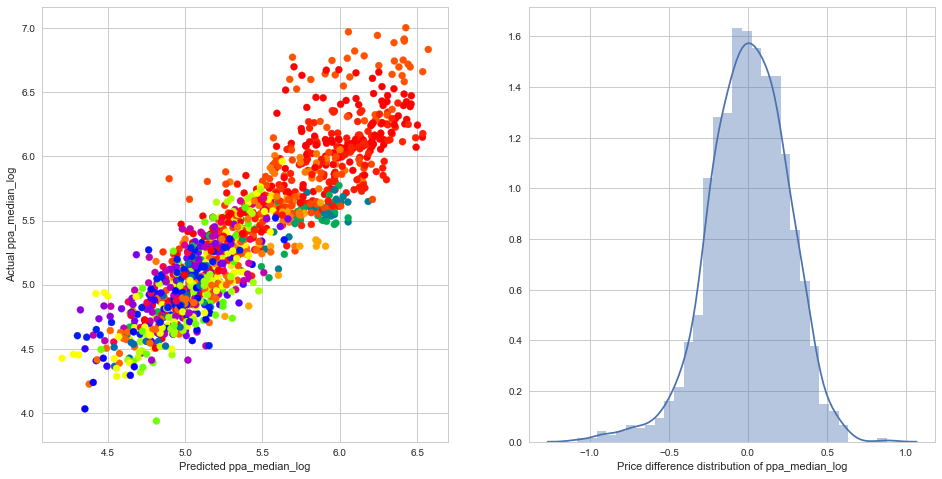

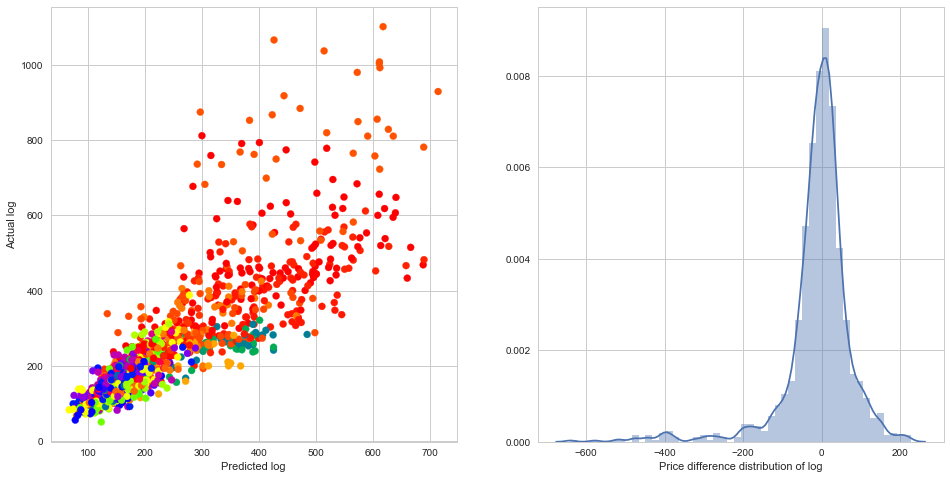

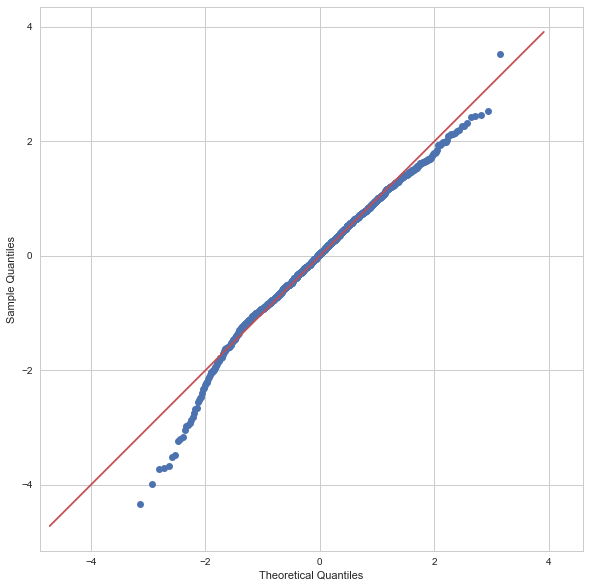

In [143]:
# print the fitted result for all area codes
print(df_cases.all.result.summary())
plot_results(df_cases.all, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.all.result.predict(df_cases.all.dfX) - df_cases.all.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     283.0
Date:                Wed, 12 Jul 2017   Prob (F-statistic):          2.87e-208
Time:                        19:59:16   Log-Likelihood:                 177.61
No. Observations:                 780   AIC:                            -339.2
Df Residuals:                     772   BIC:                            -301.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           5.0881      0.007    733.653      

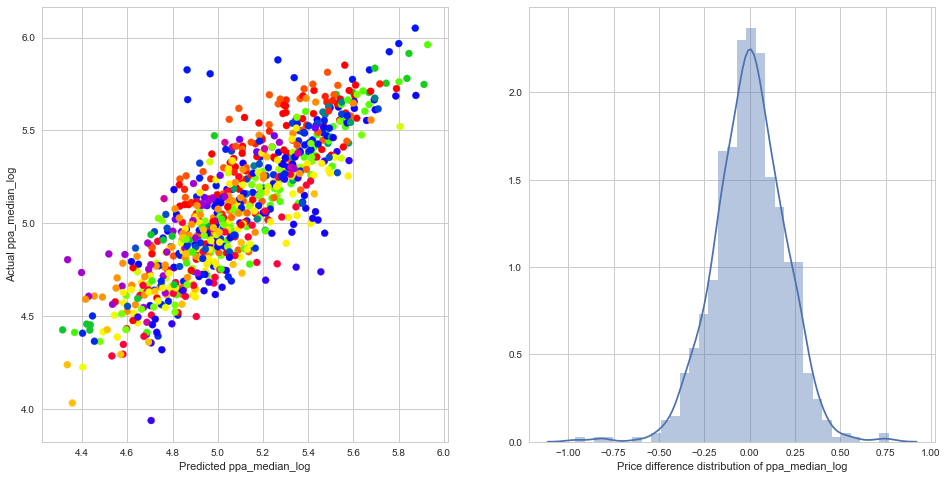

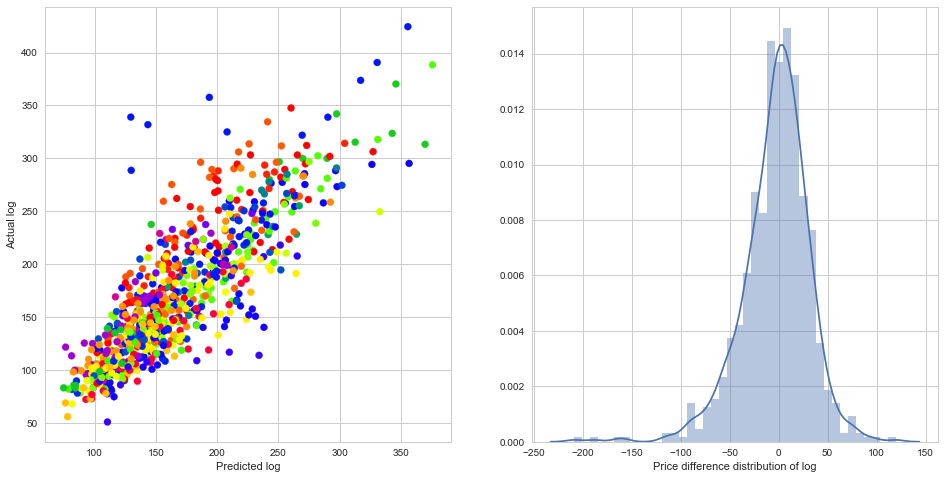

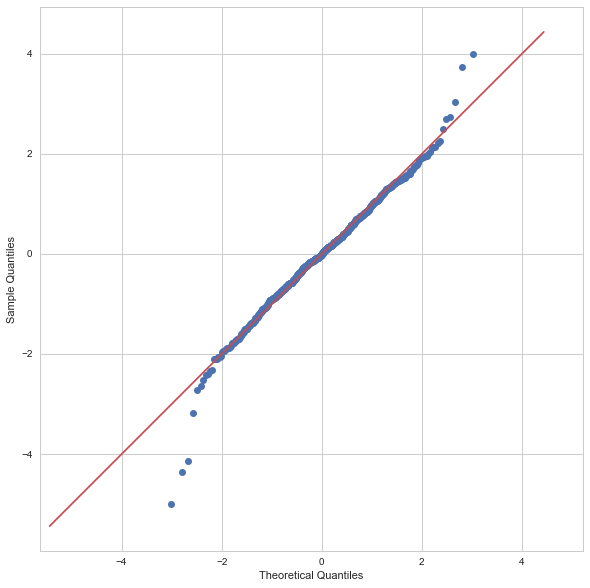

In [144]:
# print the fitted result for all area codes with label 0
print(df_cases.one.result.summary())
plot_results(df_cases.one, target)

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.one.result.predict(df_cases.one.dfX) - df_cases.one.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     80.84
Date:                Wed, 12 Jul 2017   Prob (F-statistic):           2.60e-91
Time:                        19:59:24   Log-Likelihood:                -10.913
No. Observations:                 430   AIC:                             43.83
Df Residuals:                     419   BIC:                             88.53
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                5.9161      0.012  

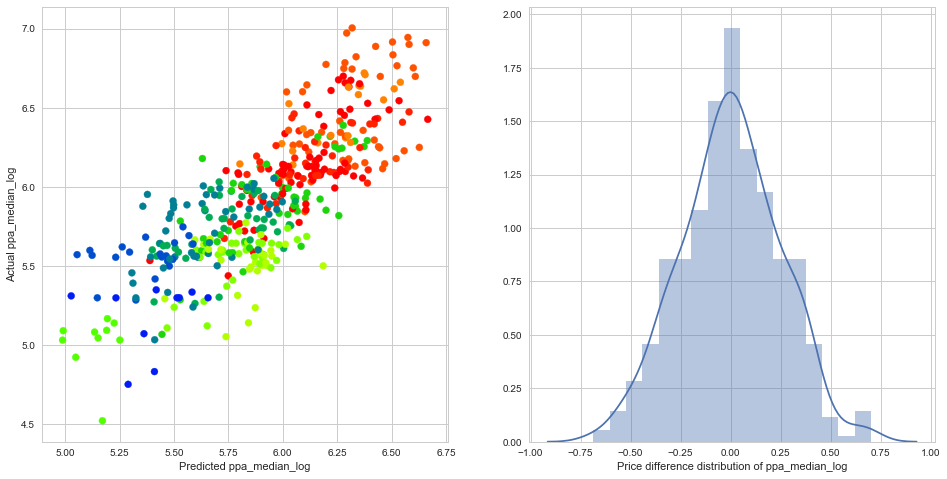

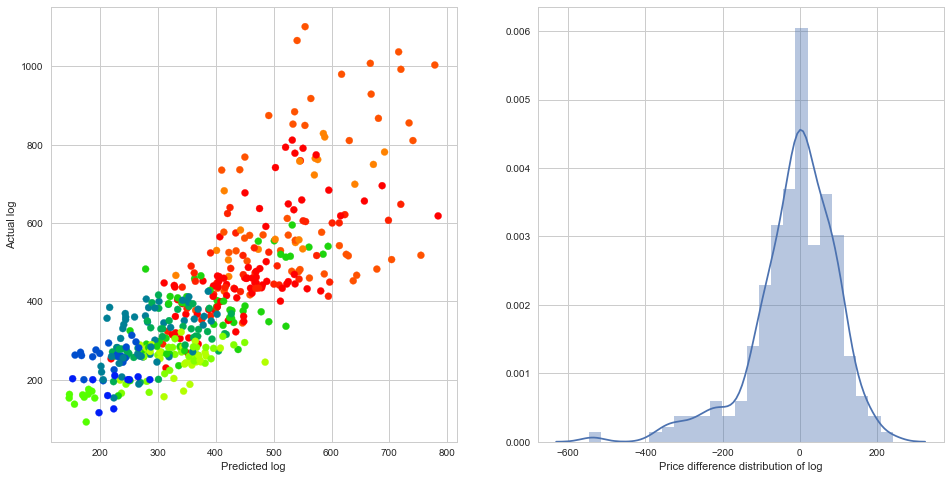

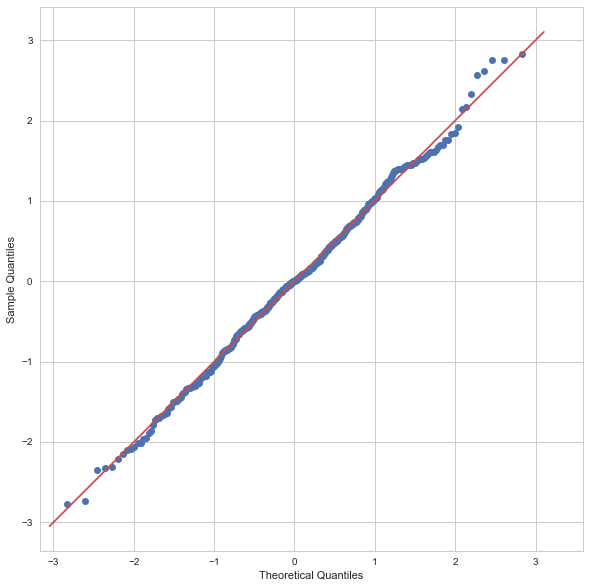

In [145]:
# print the fitted result for all area codes with label 1
print(df_cases.two.result.summary())
plot_results(df_cases.two, target)

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.two.result.predict(df_cases.two.dfX) - df_cases.two.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

In [146]:
target = 'ppa_median_log'
do_pca = True
do_f_reg = True
df_cases = Cases_df(df, target, do_pca, do_f_reg)

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     467.1
Date:                Wed, 12 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:59:36   Log-Likelihood:                -146.21
No. Observations:                1210   AIC:                             310.4
Df Residuals:                    1201   BIC:                             356.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.3823      0.008    683.127      0.0

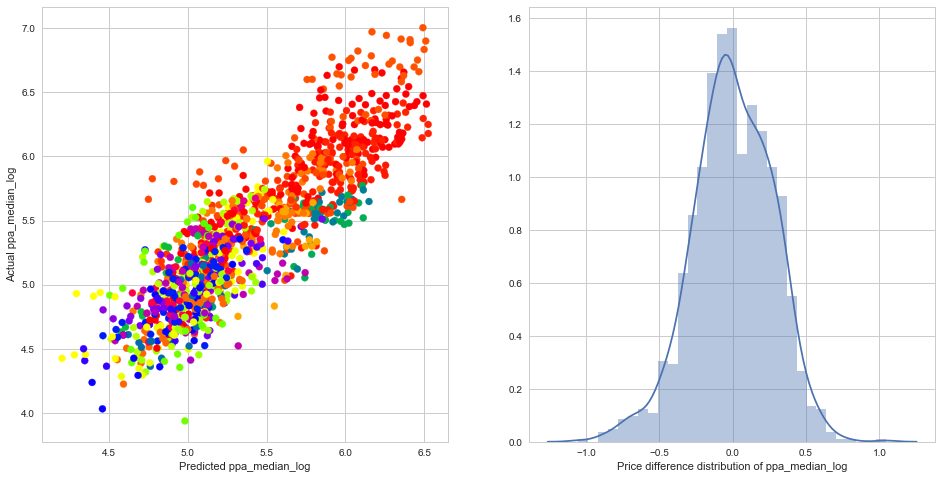

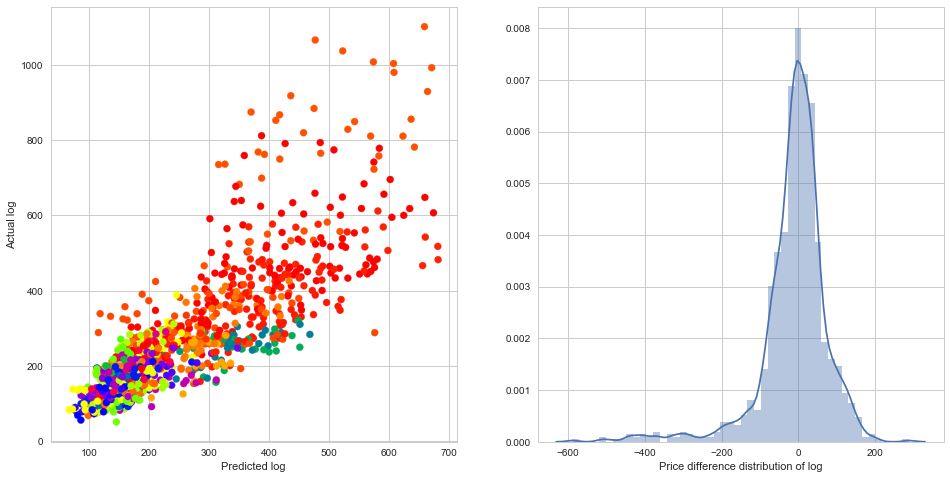

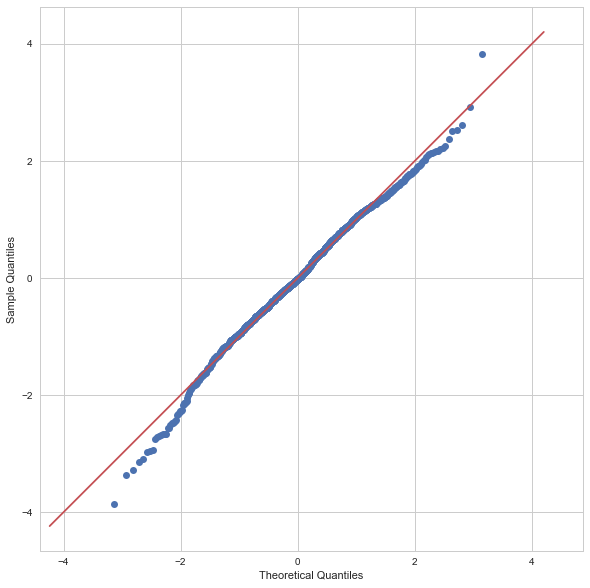

In [147]:
# print the fitted result for all area codes
print(df_cases.all.result.summary())
plot_results(df_cases.all, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.all.result.predict(df_cases.all.dfX) - df_cases.all.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 12 Jul 2017   Prob (F-statistic):          9.90e-190
Time:                        19:59:48   Log-Likelihood:                 145.31
No. Observations:                 780   AIC:                            -266.6
Df Residuals:                     768   BIC:                            -210.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.0881      0.007    702.071      0.0

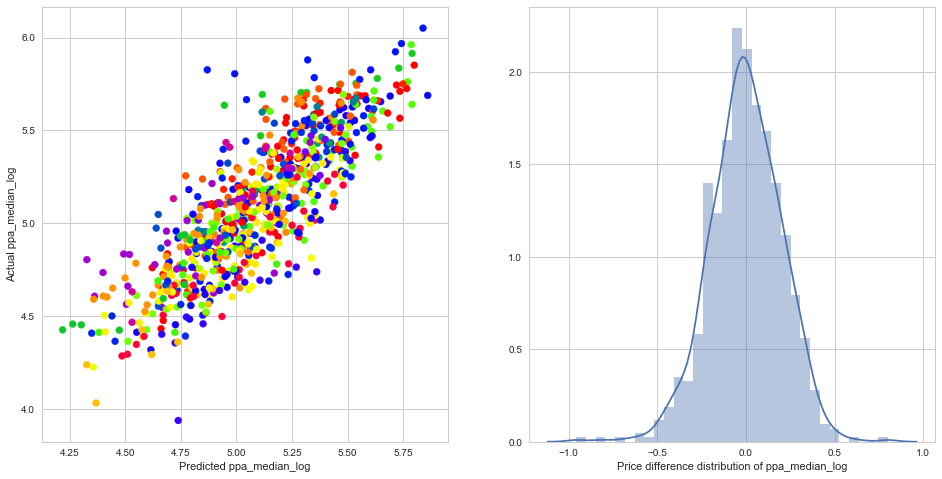

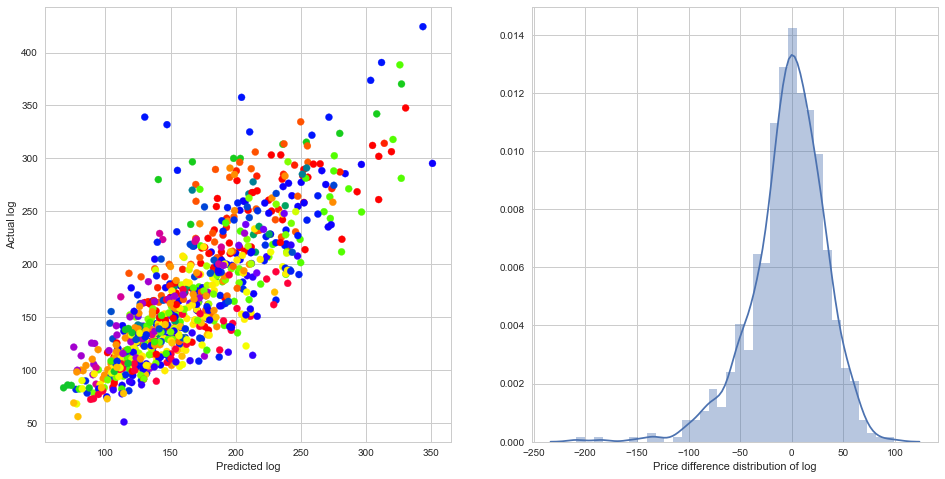

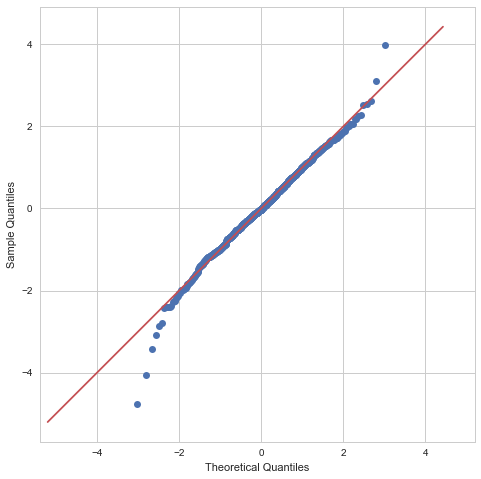

In [150]:
# print the fitted result for all area codes
print(df_cases.one.result.summary())
plot_results(df_cases.one, target)

# checking residual distribution normality
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.one.result.predict(df_cases.one.dfX) - df_cases.one.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");

                            OLS Regression Results                            
Dep. Variable:         ppa_median_log   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     86.82
Date:                Wed, 12 Jul 2017   Prob (F-statistic):           9.69e-78
Time:                        19:59:49   Log-Likelihood:                -50.205
No. Observations:                 430   AIC:                             116.4
Df Residuals:                     422   BIC:                             148.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.9161      0.013    446.914      0.0

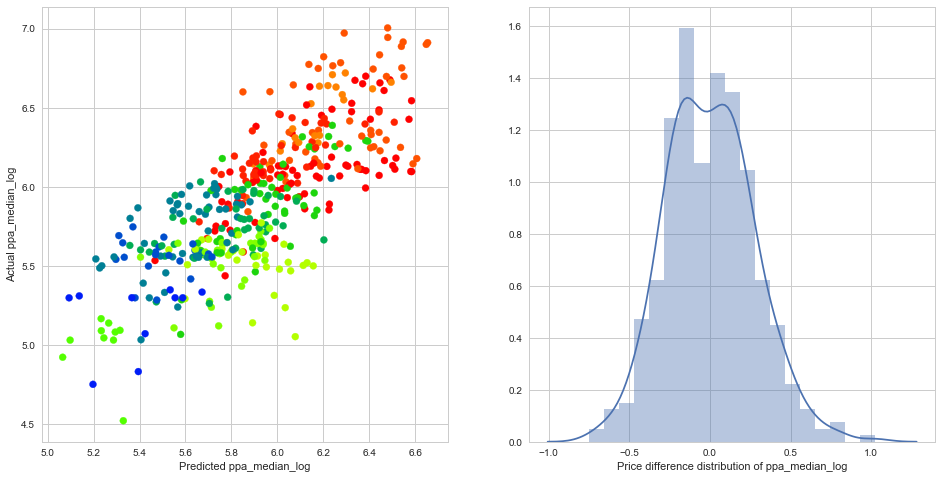

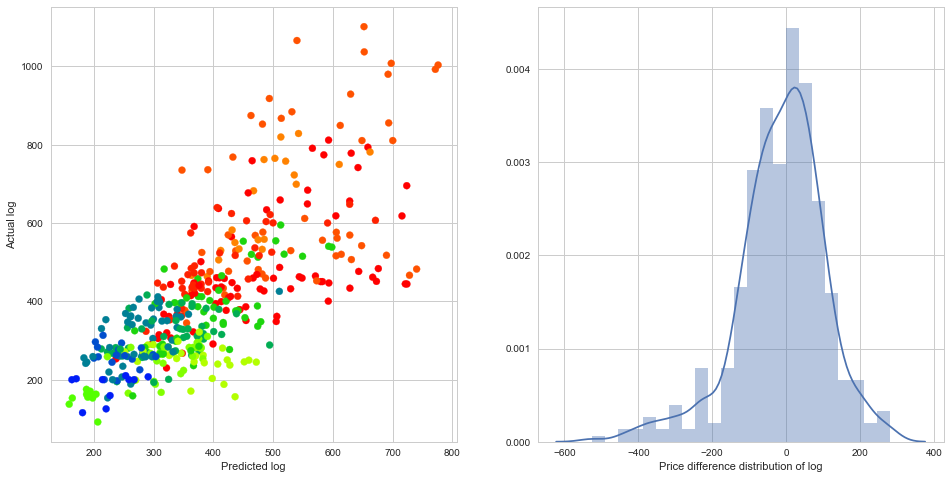

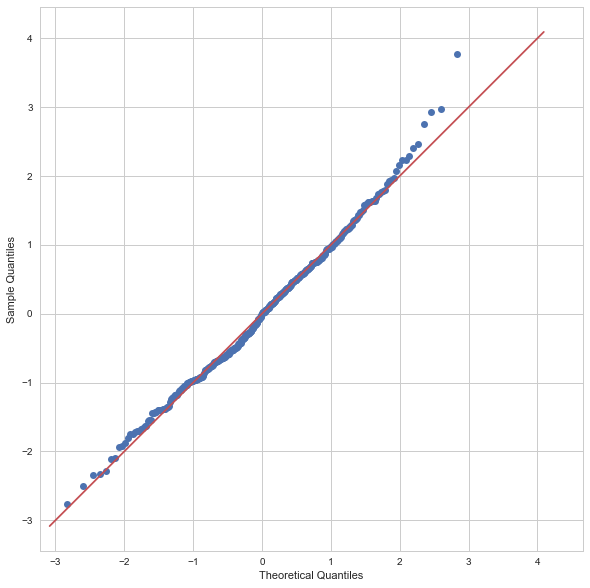

In [151]:
# print the fitted result for all area codes
print(df_cases.two.result.summary())
plot_results(df_cases.two, target)

# checking residual distribution normality
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
sm.qqplot(df_cases.two.result.predict(df_cases.two.dfX) - df_cases.two.dfy[target], fit=True, line='45', ax=ax);
plt.gca().axis("square");